In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.mixture import GaussianMixture
warnings.filterwarnings("ignore")
from scipy.spatial.distance import cdist

BORE = pd.read_csv(r"Borehole.csv", header=0, index_col=0, encoding='utf-8').reset_index()
MERGE = pd.read_csv(r"Profile_nor.csv", header=0, index_col=0, encoding='utf-8').reset_index()


In [2]:
def entropy(probabilities):
    return -np.sum(prob * np.log(prob) if prob != 0 else 0 for prob in probabilities)

def find_nearest_points(empty, BORE1):
    empty_values = empty[['X', 'Dep']].astype(float).values.reshape(1, -1)
    distances = cdist(empty_values, BORE1[['X', 'Dep']].values, metric='euclidean')
    nearest_indices = distances.argsort()[:, :2]
    nearest_points = BORE1.iloc[nearest_indices.flatten()].reset_index(drop=True)

    nearest_points['Distance'] = np.sort(distances)[:, :2].flatten()

    code_weights = {'F': 0, 'R': 0, 'S': 0, 'L': 0}

    for i, row in nearest_points.iterrows():
        weight = 1 / row['Distance'] if row['Distance'] != 0 else np.inf
        code_weights[row['Code']] += weight

    # Handle infinite weights
    if np.inf in code_weights.values():
        code_weights = {code: (1 if weight == np.inf else 0) for code, weight in code_weights.items()}

    # Normalize weights to sum to 1
    total_weight = sum(code_weights.values())
    normalized_weights = {code: weight / total_weight for code, weight in code_weights.items()}

    return list(normalized_weights.values())

def Bayes(empty, BORE1, i, TM):
    # Get the prior probabilities
    Prior = np.array(empty[["P_F", "P_R", "P_S", "P_L"]])
    likelihood = find_nearest_points(empty, BORE1)
    
    # Define transition matrix
    v = TM
    u = (1 - v) / 3
    TPT = np.array([[v, u, u, u],
                    [u, v, u, u],
                    [u, u, v, u],
                    [u, u, u, v]])
    
    # Update likelihood based on the number of iterations (i)
    TPT_m = TPT
    if i == 1:
        likelihood = np.dot(likelihood, TPT_m)
    elif i > 1:
        likelihood = np.dot(likelihood, TPT_m)
        for _ in range(i - 1):
            TPT_m = np.dot(TPT_m, TPT)
            likelihood = np.dot(likelihood, TPT_m)
    
    # Calculate posterior probabilities
    unnormalized_posterior = np.multiply(likelihood, Prior)
    Posterior = unnormalized_posterior / np.sum(unnormalized_posterior)
    
    return Posterior

def calculate_transition_matrix(data, column, order):
    matrix = pd.DataFrame(0, index=order, columns=order)
    for key in data[column].unique():
        sorted_data = data[data[column] == key].sort_values('X' if column == 'Number' else 'Dep', ascending=column != 'X')
        for i in range(len(sorted_data) - 1):
            matrix.at[sorted_data.iloc[i]['pred'], sorted_data.iloc[i + 1]['pred']] += 1
    return matrix.div(matrix.sum(axis=1), axis=0).fillna(0)

def HTM(data):
    matrix = calculate_transition_matrix(data, 'Number', ['F', 'R', 'S', 'L'])
    return np.mean(np.diagonal(matrix))

def VTM(data):
    matrix = calculate_transition_matrix(data, 'X', ['F', 'R', 'S', 'L'])
    return np.mean(np.diagonal(matrix))

# Calibrated by boreholes
def process(NUM, BORE_, data):
    
    HTM_ = HTM(data)
    Results = []
    i = 0
    
    # Forward processing
    for n in np.arange(NUM, 159, 2):
        
        empty = data[data.X == n]
        BORE1 = BORE_[BORE_.X == NUM] if i == 0 else Empty[['X', 'Dep', 'Posterior_Code']].rename(columns={'Posterior_Code': 'Code'})
        
        # Calculate posterior probabilities
        Pro = empty.apply(lambda row: Bayes(row, BORE1, i, HTM_), axis=1)
        empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']] = Pro.apply(pd.Series)
        empty['Posterior_Entropy'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].apply(entropy, axis=1)
        empty['Posterior_Code'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].idxmax(1).replace({'Posterior_F': 'F', 'Posterior_R': 'R', 'Posterior_S': 'S', 'Posterior_L': 'L'})
        
        Empty = empty.copy()
        Results.append(empty)
        i += 1
    
    # Backward processing
    BORE1 = BORE_[BORE_.X == NUM]
    i = 1
    for n in np.arange(NUM - 2, 5, -2):
        
        empty = data[data.X == n]
        BORE1 = Empty[['X', 'Dep', 'Posterior_Code']].rename(columns={'Posterior_Code': 'Code'}) if i > 1 else BORE1
        
        # Calculate posterior probabilities
        Pro = empty.apply(lambda row: Bayes(row, BORE1, i, HTM_), axis=1)
        empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']] = Pro.apply(pd.Series)
        empty['Posterior_Entropy'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].apply(entropy, axis=1)
        empty['Posterior_Code'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].idxmax(1).replace({'Posterior_F': 'F', 'Posterior_R': 'R', 'Posterior_S': 'S', 'Posterior_L': 'L'})
        
        Empty = empty.copy()
        Results.append(empty)
        i += 1
    
    Results = pd.concat(Results)

    return Results

# Calibrated by topsoil
def Topsoil(data):
    
    VTM_ = VTM(data)
    Results = []
    i = 0
    
    for n in np.arange(0, len(data.Number.unique()), 1):
        
        empty = data[data.Number == n]
        BORE1 = data[data.Number == 0][['X', 'Dep']].copy()
        BORE1['Code'] = 'F'
        
        if i > 0:
            BORE1 = Empty[['X', 'Dep', 'Posterior_Code']].rename(columns={'Posterior_Code': 'Code'})
        
        # Calculate posterior probabilities
        Pro = empty.apply(lambda row: Bayes(row, BORE1, i, VTM_), axis=1)
        empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']] = Pro.apply(pd.Series)
        empty['Posterior_Entropy'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].apply(entropy, axis=1)
        empty['Posterior_Code'] = empty[['Posterior_F', 'Posterior_R', 'Posterior_S', 'Posterior_L']].idxmax(1).replace({'Posterior_F': 'F', 'Posterior_R': 'R', 'Posterior_S': 'S', 'Posterior_L': 'L'})
        
        Empty = empty.copy()
        Results.append(empty)
        i += 1
    
    Results = pd.concat(Results)
    
    return Results

In [3]:
# GMM processing
data = MERGE[['logR_n', 'Dep_n']]
gmm = GaussianMixture(n_components=4, random_state=10).fit(data)
labels = gmm.predict(data)
probs = gmm.predict_proba(data)

# Smoothing probabilities
def smooth_probabilities(probs, dep_vals):
    smoothing_factor = np.exp(-0.5 * dep_vals ** 2) / np.sqrt(2 * np.pi)
    smoothed_probs = probs + smoothing_factor[:, np.newaxis]
    return smoothed_probs / smoothed_probs.sum(axis=1, keepdims=True)

smoothed_probs = smooth_probabilities(probs, data['Dep_n'])

# Update data with results
data = pd.concat([data, pd.DataFrame(smoothed_probs, columns=["P_L", "P_F", "P_S", "P_R"])], axis=1)
data['pred'] = labels
data[['X', 'Dep', 'Dep_n', 'Number']] = MERGE[['X', 'Dep', 'Dep_n', 'Number']]
data['pred'] = data['pred'].replace({0: "L", 1: "F", 2: "S", 3: "R"})

# Calculate entropy
data['Entropy'] = data[["P_F", "P_R", "P_S", "P_L"]].apply(entropy, axis=1)

In [4]:
BORE_=BORE[['X','Dep','Code']]

NUM=[47,63,75,115,127]

data_updated=Topsoil(data)[['logR_n','Dep_n','Posterior_F','Posterior_R','Posterior_S','Posterior_L','pred','X','Dep','Number','Entropy']]
data_updated.columns=['logR_n','Dep_n','P_F','P_R','P_S','P_L',	'pred',	'X','Dep','Number','Entropy']
ALL_results=[]

for A in NUM:

    Results=process(A,BORE_,data_updated)
    ALL_results.append(Results)
    
    data_updated=Results[['X','Dep','Number','Posterior_F','Posterior_R','Posterior_S','Posterior_L','Posterior_Code']]
    data_updated.columns=['X','Dep','Number',"P_F","P_R","P_S","P_L",'pred']
    data_updated=data_updated.sort_values('X')

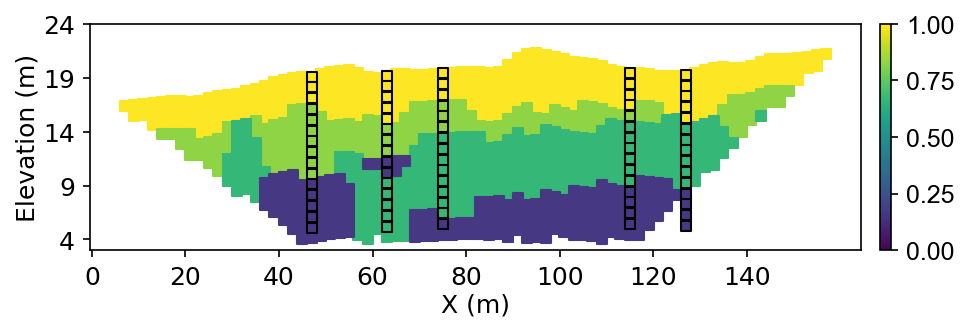

In [5]:
Results=ALL_results[4]

plt.figure(figsize=[8,2],dpi=150)

F = Results[Results['Posterior_Code']=='F']
R = Results[Results['Posterior_Code']=='R']
S  =Results[Results['Posterior_Code']=='S']
L  =Results[Results['Posterior_Code']=='L']

plt.scatter(F ['X'], F ['Dep'],c='#FDE624',marker='s',s=20, label='F')
plt.scatter(R ['X'], R ['Dep'],c='#8ED445',marker='s',s=20, label='R')
plt.scatter(S ['X'], S ['Dep'],c='#35B777',marker='s',s=20, label='S')
plt.scatter(L ['X'], L ['Dep'],c='#473883',marker='s',s=20, label='L')
    
plt.rcParams['font.family']='Arial'
plt.yticks(np.arange(4,25,5))
plt.xticks(np.arange(0,160,20))
plt.tick_params(labelsize=12)
plt.ylim(3,24)
plt.xlabel('X (m)',fontsize=12, color='k',labelpad=2)
plt.ylabel('Elevation (m)',fontsize=12, color='k',labelpad=2)
cbar=plt.colorbar(aspect=20,pad=0.02)
cbar.ax.tick_params(labelsize=12)

BORE1=BORE[['X','Dep','Code']]#
F = BORE1[BORE1['Code']=='F']
R  =BORE1[BORE1['Code']=='R']
L  =BORE1[BORE1['Code']=='L']
S  =BORE1[BORE1['Code']=='S']
#  
plt.scatter(F ['X'], F ['Dep'],c='#FDE624',marker='s',s=20, label='F',edgecolors='black',linewidths=0.99)
plt.scatter(R ['X'], R ['Dep'],c='#8ED445',marker='s',s=20, label='R',edgecolors='black',linewidths=0.99)
plt.scatter(S ['X'], S ['Dep'],c='#35B777',marker='s',s=20, label='L',edgecolors='black',linewidths=0.99)
plt.scatter(L ['X'], L ['Dep'],c='#473883',marker='s',s=20, label='S',edgecolors='black',linewidths=0.99)
